# Covid Data Collection, Forecasting & Clustering
## Utilising Real World Data, can we look at forecasting cases, and also clustering States into similar characteristics of their Covid profile?

Having trawled a few sites, and looked at what data is out there, I came up with the following set of sources that I think would be useful to start to collate data across things like Covid stats, details of what public service / places are open / closed, other prevelant clinical conditions per state etc:

| Source                       | Source                                                                                                                                                                                           | Description                           | Level  | Update Frequency |
| ---------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------- | ------ | ---------------- |
| Google Mobility data         | gstatic.com/covid19/mobility/Global_Mobility_Report.csv                                                       | Google Mobility data                  | County | Adhoc            |
| John  Hopkins - Confirmed US | raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv                                               | Confirmed Cases - Time Series         | County | Daily            |
| John  Hopkins - Deaths US    | raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv                                                  | Confirmed Deaths - Time Series        | County | Daily            |
| Ancilliary data              | Misc_ML.csv                                                                                                                                                                                      | Used to get State code from Full Name | State  | N/A              |
| CovidTracking.com            | covidtracking.com/api/v1/states/daily.csv                                                                                           | Daily Covid information               | State  | Daily            |
| Boston University            | docs.google.com/spreadsheets/d/1zu9qEWI8PsOI_i8nI_S29HDGHlIp2lfVMsGxpQ5tvAQ/edit#gid=0 | Covid collation re State Policy       | State  | Adhoc            |
| Chronic Conditions           | Chronic_Conditions_Prevalence_2017.xlsx                                                                                                                                                          | Chronic Condition Prevalence          | County | Adhoc            |
| 2016 Vote data               | raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/US_County_Level_Presidential_Results_12-16.csv                                                            | 2016 electorial vote data             | County | N/A              |

#### Let's start with a few imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

### The `get_all_data` function is the guts of the Feature Engineering
Here we pull in, cleanse and merge to a State level for:
- Google Mobility data
- Confirmed Covid case data
- Covid death data
- Hospitalisation data
- Employment / Homlessness rates
- Chronic Conditions for over 65's
- 2016 Vote Data
- State Wide StayAtHome / Closure rules

All normalised out to per 100k of the State population

In [2]:
def get_all_data(path):
    """Compile mobility, case, and policy data for COVID-19 modeling.

    Inputs:
    path           - File path

    Outputs:
    df_all_data    - County-level time series dataset
    df_state_data  - State-level summaries
    """
    
    ##############################
    # Get the Google Mobility data
    ##############################
    df_google_mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', low_memory=False)
    df_google_mobility = df_google_mobility.loc[df_google_mobility['country_region'] == 'United States']
    df_google_mobility = df_google_mobility.drop(df_google_mobility[df_google_mobility['sub_region_1'].isna()].index)
    df_google_mobility = df_google_mobility.drop(df_google_mobility[df_google_mobility['sub_region_2'].notna()].index)
    df_google_mobility.rename({'retail_and_recreation_percent_change_from_baseline' : 'retail',
                           'grocery_and_pharmacy_percent_change_from_baseline' : 'grocery.and.pharmacy',
                           'parks_percent_change_from_baseline' : 'parks',
                           'transit_stations_percent_change_from_baseline' : 'transit.stations',
                           'workplaces_percent_change_from_baseline' : 'workplaces',
                           'residential_percent_change_from_baseline': 'residential'}, axis=1, inplace=True)
    df_google_mobility.to_csv(path+'Data/Google_Mobility_Report.csv', index=False)
    
    #################
    # Get df_all_data
    #################
    df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
    #.to_csv(path+'Data/df_confirmed.csv', index=False)
   
    df_confirmed.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_'], axis=1, inplace=True)
    
    df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
    #df_deaths.to_csv(path+'Data/df_deaths.csv', index=False)
    
    metadata = df_deaths[['Combined_Key', 'Lat', 'Long_', 'Province_State', 'Population']]
    
    df_deaths.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Population'], axis=1, inplace=True)
    
    # Sum up df_confirmed per County
    df_tmp = df_confirmed.groupby('Combined_Key')[df_confirmed.columns[1:]].sum()
    df_tmp = pd.DataFrame(df_tmp.T.stack()).reset_index()
    df_tmp.columns = ['Date', 'Combined_Key', 'Confirmed']
    df_tmp = df_tmp[df_tmp['Confirmed'] > 1]
    df_tmp['Confirmed_size'] = df_tmp['Confirmed'].pow(0.5)
    
    # Sum up df_deaths per County
    df_tmp1 = df_deaths.groupby('Combined_Key')[df_deaths.columns[1:]].sum()
    # Transpose and Stack, etc
    df_tmp1 = pd.DataFrame(df_tmp1.T.stack()).reset_index()
    df_tmp1.columns = ['Date', 'Combined_Key', 'Deaths']
    df_tmp1 = df_tmp1[df_tmp1['Deaths'] > 1]
    df_tmp1['Deaths_size'] = df_tmp1['Deaths'].pow(0.5)
    
    df_all_data = df_tmp.merge(df_tmp1, on=['Combined_Key', 'Date'], how='left').fillna(0)
    df_all_data['Date'] = pd.to_datetime(df_all_data['Date'], format="%m/%d/%y")
    df_all_data['Date'] = df_all_data['Date'].dt.date
    df_all_data['Date'] = df_all_data['Date'].astype(str)
    df_all_data = df_all_data.sort_values('Date', ascending=True)
    df_all_data.Date = pd.Categorical(df_all_data.Date)
    df_all_data["Day"] = df_all_data["Date"].cat.codes

    df_all_data = df_all_data.merge(metadata, on='Combined_Key')
    
    df_all_data = df_all_data.merge(df_google_mobility[['retail', 'grocery.and.pharmacy', 'parks', 'transit.stations',
                                             'workplaces', 'residential', 'sub_region_1', 'date']], 
                                            left_on=['Province_State', 'Date'], 
                                            right_on=['sub_region_1', 'date'],
                                            how='left').drop(['sub_region_1', 'date'], axis=1).fillna(0)

    df_AW_data = pd.read_csv(path+'Data/Misc_ML.csv')
    df_AW_data = df_AW_data[['state', 'NAME', 'test_per_100k']]
        
    df_all_data = df_all_data.merge(df_AW_data, left_on='Province_State', right_on='NAME').drop(['NAME'], axis=1)
    df_all_data[['Confirmed_size', 'Deaths_size']] = df_all_data[['Confirmed_size', 'Deaths_size']].astype(float)
    
    
    ##########################
    # Add Hospitalisation Data
    ##########################
    df_tmp_hospitalised = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv', parse_dates=['date'], usecols=['date', 'state', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently'])
    df_tmp_hospitalised.dropna(subset=['hospitalizedCurrently', 'inIcuCurrently'], how='all', inplace=True)
    df_tmp_hospitalised.rename({'date' : 'Date'}, axis=1, inplace=True)
    df_tmp_hospitalised = df_tmp_hospitalised.fillna(0)
    df_tmp_hospitalised.loc[df_tmp_hospitalised.hospitalizedCurrently == 0 , 'hospitalizedCurrently'] = df_tmp_hospitalised.inIcuCurrently
    df_tmp_hospitalised['Date'] = pd.to_datetime(df_tmp_hospitalised['Date'], format="%Y-%m-%d")
    df_tmp_hospitalised['Date'] = df_tmp_hospitalised['Date'].dt.date
    df_tmp_hospitalised['Date'] = df_tmp_hospitalised['Date'].astype(str)
    df_all_data = df_all_data.merge(df_tmp_hospitalised, on=['state', 'Date'], how='left').fillna(0)

    
    ######################
    # Add Demographic Data
    ######################
    df_tmp_demog = pd.read_csv(path+'Data/COVID-19 US state policy database.csv', usecols=['State',
                                                                                          'Number Homeless (2019)',
                                                                                          'Percent Unemployed (2018)',
                                                                                          'Percent living under the federal poverty line (2018)',
                                                                                          'Percent at risk for serious illness due to COVID',
                                                                                          'All-cause deaths 2016']).dropna()
    df_tmp_demog.rename({'State' : 'Province_State',
                        'Number Homeless (2019)' : 'HomelessNumber',
                        'Percent Unemployed (2018)' : 'EmployedPerc',
                        'Percent living under the federal poverty line (2018)' : 'PovertyPerc',
                        'Percent at risk for serious illness due to COVID' : 'SeriousIllnessRiskPerc',
                        'All-cause deaths 2016' : 'AllCauseDeaths'}, axis=1, inplace=True)
    df_all_data = df_all_data.merge(df_tmp_demog, on=['Province_State'], how='left')
    
    
    ######################################
    # Add Chronic Conditions for over 65's
    ######################################
    df_tmp_chronic = pd.read_excel(path+'Data/Chronic_Conditions_Prevalence_2017.xlsx', sheet_name='Beneficiaries 65 Years and Over')
    df_tmp_chronic = df_tmp_chronic.drop(df_tmp_chronic.loc[df_tmp_chronic['County'] == '  '].index)
    df_tmp_chronic = df_tmp_chronic.replace("* ", 0)
    df_tmp_chronic['State'] = df_tmp_chronic['State'].apply( lambda x : x.split()[0] )
    df_tmp_chronic['County'] = df_tmp_chronic['County'].apply( lambda x : x.split()[0] )
    df_all_data['County'] = df_all_data['Combined_Key'].apply( lambda x : x.split(",")[0] )
    df_all_data = df_all_data.merge(df_tmp_chronic, left_on=['Province_State','County'], right_on=['State','County'], how='left').drop('State', axis=1)
    
    
    ####################
    # Add 2016 Vote Data
    ####################
    df_tmp_votes = pd.read_csv('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/US_County_Level_Presidential_Results_12-16.csv',
                            usecols=['votes_dem_2016', 'votes_gop_2016', 'state_abbr', 'county_name'])
    df_tmp_votes['county_name'] = df_tmp_votes['county_name'].apply( lambda x : x.split()[0] )
    df_tmp_votes.drop_duplicates(inplace=True)
    df_all_data = df_all_data.merge(df_tmp_votes, left_on=['state','County'], right_on=['state_abbr','county_name'], how='left').drop(['state_abbr','county_name'], axis=1)


    ###################
    # Get df_state_data
    ###################
    df_tmp = df_all_data.loc[df_all_data['Date'] == max(df_all_data['Date']),['Population', 'Confirmed', 'Deaths']].groupby(df_all_data['state']).sum().astype(int)
    
    df_tmp1 = df_all_data.loc[df_all_data['Date'] == max(df_all_data['Date']),['Date', 'Province_State', 'state']].drop_duplicates()
    
    df_state_data = df_tmp.merge(df_tmp1,on='state')
    df_state_data['Deaths_size'] = df_state_data['Deaths'].pow(0.5)
    df_state_data['Confirmed_size'] = df_state_data['Confirmed'].pow(0.5)
    df_state_data.to_csv(path+'Data/df_state_data.csv', index=False)


    ############################################################################################################################
    # Collate State Wide StayAtHome, BusinessesClosed, RestaurantsClosed, GymsClosed, CinemasClosed, SuspendedElectiveProcedures
    ############################################################################################################################
    df_tmp_restrictions = pd.read_csv(path+'Data/COVID-19 US state policy database.csv', usecols=['State',
                                            'Stay at home/ shelter in place', 'End/relax stay at home/shelter in place',
                                            'Closed non-essential businesses', 'Reopen businesses', 
                                            'Closed restaurants except take out', 'Reopen restaurants',
                                            'Closed gyms', 'Repened gyms',
                                            'Closed movie theaters', 'Reopened movie theaters',
                                            'Suspended elective medical/dental procedures', 'Resumed elective medical procedures']).dropna()
    df_tmp_restrictions.rename({'State' : 'Province_State',
                        'Stay at home/ shelter in place' : 'StayAtHome_Start',
                        'End/relax stay at home/shelter in place' : 'StayAtHome_End',
                        'Closed non-essential businesses' : 'BusinessesClosed_Start',
                        'Reopen businesses' : 'BusinessesClosed_End',
                        'Closed restaurants except take out' : 'RestaurantsClosed_Start',
                        'Reopen restaurants' : 'RestaurantsClosed_End',
                        'Closed gyms' : 'GymsClosed_Start',
                        'Repened gyms' : 'GymsClosed_End',
                        'Closed movie theaters' : 'CinemasClosed_Start',
                        'Reopened movie theaters' : 'CinemasClosed_End',
                        'Suspended elective medical/dental procedures' : 'SuspendedElectiveProcedures_Start',
                        'Resumed elective medical procedures' : 'SuspendedElectiveProcedures_End'}, axis=1, inplace=True)
    
    df_tmp_TS = pd.DataFrame(columns =  ['Date', 'Province_State', 'StayAtHome', 'BusinessesClosed', 'RestaurantsClosed', 'GymsClosed', 'CinemasClosed', 'SuspendedElectiveProcedures'])
    row_index = 0
    
    for state in df_state_data['Province_State']:
        for restriction in ['StayAtHome', 'BusinessesClosed', 'RestaurantsClosed', 'GymsClosed', 'CinemasClosed', 'SuspendedElectiveProcedures']:
            start = df_tmp_restrictions.loc[df_tmp_restrictions['Province_State'] == state, restriction+'_Start'].values[0]
            if not start == "0":
                start = pd.to_datetime(start)
                end = df_tmp_restrictions.loc[df_tmp_restrictions['Province_State'] == state, restriction+'_End'].values[0]
                if end == "0":
                    end = pd.to_datetime('today')
                else:
                    end = pd.to_datetime(end)
                    
                for dt in pd.date_range(start=start, end=end, freq='d'):
                    existingIndexes = df_tmp_TS.loc[(df_tmp_TS['Date']==dt) & (df_tmp_TS['Province_State']==state)].index
                    if len(existingIndexes) == 0:
                        df_tmp_TS.loc[row_index, 'Date'] = dt
                        df_tmp_TS.loc[row_index, 'Province_State'] = state
                        df_tmp_TS.loc[row_index, restriction] = 1
                        row_index+=1
                    else:
                        df_tmp_TS.loc[existingIndexes[0], restriction] = 1
              
    df_tmp_TS['Date'] = df_tmp_TS['Date'].astype('datetime64[ns]')
    df_tmp_TS['Date'] = df_tmp_TS['Date'].dt.date
    df_tmp_TS['Date'] = df_tmp_TS['Date'].astype(str)
    #df_tmp_TS = df_tmp_TS.fillna(0)
    df_all_data = df_all_data.merge(df_tmp_TS, on=['Date', 'Province_State'], how='left').fillna(0)

    df_all_data.to_csv(path+'Data/df_all_data.csv', index=False)
      
    return df_all_data, df_state_data

### The `get_forecast_data` function creates the Time Series data to be used for forecasting
Here we pull in, cleanse and merge to a State level for:
- Chronic Conditions for over 65's
- 2016 Vote Data
- Confirmed Covid case data
- Covid death data

In [3]:
def get_forecast_data(path, day0_feature, day0_minimum, checkpointInterval):
    """Compile state-level summaries and time series for COVID-19 forecasting.

    Inputs:
    path                  - File path
    day0_feature          - Column name for start of time series
    day0_minimum          - Minimum value for day0_feature to be included
    checkpointInterval    - Interval between checkpoints

    Outputs:
    df_all_states         - State-level summaries
    df_all_states_TS      - State-level time series
    """
    
    df_all_data_baseline = pd.read_csv(path+'Data/df_all_data.csv')
     
    ######################################
    # Get Chronic Conditions for over 65's
    ######################################
    df_tmp_chronic = pd.read_excel('Data/Chronic_Conditions_Prevalence_2017.xlsx', sheet_name='Beneficiaries 65 Years and Over')
    df_tmp_chronic = df_tmp_chronic.drop(df_tmp_chronic.loc[df_tmp_chronic['County'] != '  '].index)
    df_tmp_chronic = df_tmp_chronic.drop(df_tmp_chronic.loc[df_tmp_chronic['State'] == 'National '].index)
    df_tmp_chronic = df_tmp_chronic.drop(df_tmp_chronic.loc[df_tmp_chronic['State'] == 'Unknown '].index)
    df_tmp_chronic = df_tmp_chronic.drop(['County', 'State/County FIPS Code'], axis=1)
    df_tmp_chronic = df_tmp_chronic.replace("* ", 0)
    df_tmp_chronic['State'] = df_tmp_chronic['State'].apply( lambda x : x[:-1] )
    df_tmp_chronic.columns=['Province_State', 'AlcoholAbuse(%)', 'Alzheimer(%)', 'Arthritis(%)', 'Asthma(%)', 'AtrialFibrillation(%)',
           'Autism(%)', 'Cancer(%)', 'Kidney(%)', 'COPD(%)', 'Depression(%)', 'Diabetes(%)', 'DrugAbuse(%)', 'HIV/AIDS(%)',
           'HeartFailure(%)', 'Hepatitis(%)', 'Hyperlipidemia(%)', 'Hypertension(%)', 'IschemicHeartDisease', 'Osteoporosis(%)',
           'Schizophrenia(%)', 'Stroke(%)']
    
    
    ####################
    # Get 2016 Vote Data
    ####################
    df_tmp_votes = pd.read_csv('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/US_County_Level_Presidential_Results_12-16.csv',
                            usecols=['votes_dem_2016', 'votes_gop_2016', 'state_abbr'])
    df_tmp_votes = df_tmp_votes.groupby('state_abbr').sum().astype(int).reset_index()
    df_tmp_votes.columns=['state', 'votes_dem', 'votes_gop']
    
    
    #########################
    # Get Covid specific Data
    #########################
    df_tmp_covid = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv', parse_dates=['date'], usecols=['date', 'state', 'positive', 'negative', 'pending',
                                                                                                                'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
                                                                                                                'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
                                                                                                                'recovered', 'death', 'hospitalized', 'totalTestResults', 'hospitalizedIncrease', 'negativeIncrease',
                                                                                                                'positiveIncrease', 'totalTestResultsIncrease'])
    df_tmp_covid.rename({'date' : 'Date'}, axis=1, inplace=True)
    df_tmp_covid = df_tmp_covid.fillna(0)
    df_tmp_covid.loc[df_tmp_covid.hospitalizedCurrently == 0 , 'hospitalizedCurrently'] = df_tmp_covid.inIcuCurrently
    df_tmp_covid['Date'] = pd.to_datetime(df_tmp_covid['Date'], format="%Y-%m-%d")
    df_tmp_covid['Date'] = df_tmp_covid['Date'].dt.date
    df_tmp_covid['Date'] = df_tmp_covid['Date'].astype(str)
  
    
    ######################
    # Tidy Population Data
    ######################

    dict_Population = { 'AK': 641885, 'AL': 3966117, 'AR': 2431178, 'AZ': 5668172, 'CA': 33386271, 'CO': 4733182, 'CT': 2903857, 'DE': 766315, 'FL': 16396571, 'GA': 8769860, 'HI': 1144720, 'DC': 3122605, 'IA': 3155000, 'ID': 1426229, 'IL': 10621629, 'IN': 5481493, 'KS': 2401168, 'KY': 3629389, 'LA': 3869353, 'MA': 5560966, 'MD': 5034555, 'ME': 1043020, 'MI': 8111106, 'MN': 4631892, 'MO': 4962977, 'MS': 2436118, 'MT': 840690, 'NC': 8409430, 'ND': 624315, 'NE': 1584007, 'NH': 1075062, 'NJ': 7463801, 'NM': 1697570, 'NV': 2499657, 'NY': 16275146, 'OH': 9465116, 'OK': 3232821, 'OR': 3368951, 'PA': 10204534, 'RI': 849236, 'SC': 4030966, 'SD': 706488, 'TN': 5504777, 'TX': 24261733, 'UT': 2726635, 'VA': 6982812, 'VT': 486701, 'WA': 6186055, 'WI': 4724670, 'WV': 1421917, 'WY': 477391 }
    tmp_Population = pd.DataFrame.from_dict(list(dict_Population.items()))
    tmp_Population.columns = ['state', 'Population']    

    df_all_states = pd.DataFrame()
    df_all_states_TS = pd.DataFrame()
    
    stateList = list(df_all_data_baseline.sort_values(by='Province_State')['Province_State'].unique())
        
    for state in stateList:
        #print(state)
        if not state in ['District of Columbia']:
            # Get State level data from the latest day's entry
            df_state_data = df_all_data_baseline.loc[(df_all_data_baseline['Date'] == max(df_all_data_baseline['Date'])) & (df_all_data_baseline['Province_State'] == state),
                          ['Province_State', 'state', 'HomelessNumber', 'EmployedPerc', 'PovertyPerc', 'SeriousIllnessRiskPerc']].drop_duplicates()
            df_state_data = df_state_data.merge(df_tmp_chronic, on='Province_State')
            stateCode = df_state_data['state'].values[0]
            
            statePopulation = tmp_Population.loc[tmp_Population.state == stateCode]['Population'].values[0]     

            df_state_data = df_state_data.merge(df_tmp_votes, on='state')
            df_state_data['HomelessNumber'] = df_state_data['HomelessNumber'].replace(',','', regex=True)
            df_state_data['HomelessNumber'] = df_state_data['HomelessNumber'].astype(int)
            df_state_data[['HomelessNumber', 'votes_dem', 'votes_gop']] = df_state_data[['HomelessNumber', 'votes_dem', 'votes_gop']].apply( lambda x : (x / statePopulation) * 100000 )
       
            df_tmp = pd.DataFrame(df_all_data_baseline.loc[df_all_data_baseline['Province_State'] == state, ['retail', 'grocery.and.pharmacy', 'parks', 'transit.stations', 'workplaces', 'residential']].mean()).T
            df_tmp['Province_State'] = state
            df_state_data = df_state_data.merge(df_tmp, on='Province_State')  
        
            df_state_TS_data = df_all_data_baseline.loc[df_all_data_baseline['Province_State'] == state, ['Date', 'Confirmed', 'Deaths']].groupby('Date').sum().reset_index()
            df_state_TS_data['Province_State'] = state
            df_state_TS_data['state'] = stateCode
            df_state_data = df_state_data.merge(tmp_Population, on='state')              
        
            df_state_TS_data = df_state_TS_data.merge(df_tmp_covid, on=['state', 'Date'], how='left').fillna(0)
            
            df_tmp = df_all_data_baseline.loc[df_all_data_baseline['Province_State'] == state, ['Date', 'Province_State', 'StayAtHome', 'BusinessesClosed', 'RestaurantsClosed', 'GymsClosed', 'CinemasClosed', 'SuspendedElectiveProcedures']].drop_duplicates()
            df_state_TS_data = df_state_TS_data.merge(df_tmp, on=['Province_State', 'Date'], how='left').fillna(0)
        
            # Reduce to ensure data starts from agreed Day Zero
            df_state_TS_data = df_state_TS_data.loc[df_state_TS_data[day0_feature] >= day0_minimum]
            
            # Reduce to the maximum number of days ALL States have, based on the smallest sample
#            df_state_TS_data = df_state_TS_data[:maxDays]
        
            df_state_TS_data.Date = pd.Categorical(df_state_TS_data.Date)
            df_state_TS_data["Day"] = df_state_TS_data["Date"].cat.codes
            siteMaxDays = max(df_state_TS_data.Day)
            df_state_data['MaxDays'] = siteMaxDays
            
            # Current Snapshot of Positive and Deaths
            df_tmp1 = pd.DataFrame(df_state_TS_data[['positive','death']].sum()).T.astype(int)
            df_tmp1.columns=['Confirmed', 'Deaths']
            df_state_data = df_state_data.join(df_tmp1)
            
            ###############################
            # Start calculating Checkpoints
            ###############################
            
            for chk in range(1,10):
                
                if chk*checkpointInterval < siteMaxDays:
                    try:
                        df_tmp = df_state_TS_data.iloc[:chk*checkpointInterval]
                        df_tmp = pd.DataFrame(df_tmp[['StayAtHome', 'BusinessesClosed', 'RestaurantsClosed', 'GymsClosed', 'CinemasClosed', 'SuspendedElectiveProcedures']].sum()).T
                
                        for col in df_tmp.columns:
                            df_tmp.rename( { col: "Day"+str(chk*checkpointInterval)+"_"+col }, axis=1, inplace=True)
                
                        df_state_data = df_state_data.join(df_tmp)
                
                        # Sum up state level data
                        df_tmp1 = df_state_TS_data.iloc[:chk*checkpointInterval]
                        df_tmp1 = pd.DataFrame(df_tmp1[['positive', 'negative', 'pending', 'hospitalizedCurrently',
                                               'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
                                               'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'death',
                                               'hospitalized', 'totalTestResults', 'hospitalizedIncrease',
                                               'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']].sum()).T.astype(int)
                        # Convert all to per 100k of the State population
                        df_tmp1 = df_tmp1.apply( lambda x : (x / statePopulation) * 100000 )
                        
                        for col in df_tmp1.columns:
                            df_tmp1.rename( { col: "Day"+str(chk*checkpointInterval)+"_"+col }, axis=1, inplace=True)
                        df_state_data = df_state_data.join(df_tmp1)
                        
                    except:
                        pass
                

            
            df_all_states = df_all_states.append(df_state_data)
            
            # Day by Day State Level data
            df_state_TS_data = pd.DataFrame(df_state_TS_data[['Date', 'Day', 'positive', 'negative', 'pending', 'hospitalizedCurrently',
                                                   'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
                                                   'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'death',
                                                   'hospitalized', 'totalTestResults', 'hospitalizedIncrease',
                                                   'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']])
            for vr in ['positive', 'negative', 'pending', 'hospitalizedCurrently',
                        'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
                        'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'death',
                        'hospitalized', 'totalTestResults', 'hospitalizedIncrease',
                        'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']:
                df_state_TS_data[vr] = df_state_TS_data[vr].astype(int)

#            df_state_TS_data = df_state_TS_data.iloc[:maxDays]
            df_state_TS_data['Province_State'] = state
            df_state_TS_data['state'] = stateCode
            # Convert all to per 100k of the State population
            factors_to_convert = ['positive', 'negative', 'pending', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
                                'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'death', 'hospitalized', 'totalTestResults', 'hospitalizedIncrease',
                                'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']
            df_state_TS_data[factors_to_convert] = df_state_TS_data[factorsToConvert].apply( lambda x : (x / statePopulation) * 100000 )
            df_all_states_TS = df_all_states_TS.append(df_state_TS_data)
    
    df_all_states.to_csv(path+'Data/df_all_states.csv', index=False)
    df_all_states_TS.to_csv(path+'Data/df_all_states_TS.csv', index=False)

    return df_all_states, df_all_states_TS

### The 'get_forecast' function executes a simple ARIMA forecast for a desired data point

In [4]:
def get_forecast(path, day0_feature, forecast_days):
    
    """Generate forecasts for COVID-19 case and death time series.

    Inputs:
    path             - File path
    day0_feature     - Column name for start of time series
    forecast_days    - Number of days to forecast

    Outputs:
    df_forecast_data - Forecasted time series
    """
    
    df_all_states = pd.read_csv(path+'Data/df_all_states.csv')
    df_all_states_TS = pd.read_csv(path+'Data/df_all_states_TS.csv')
    
    df_forecast_data = pd.DataFrame()

    for state in df_all_states['Province_State']:
        #print(state)

        plot_data = df_all_states_TS.loc[df_all_states_TS['Province_State'] == state, ['Date', day0_feature]]#.reset_index().drop('index', axis=1)
        plot_data.loc[plot_data[day0_feature] == 0, day0_feature] = plot_data[day0_feature].mean()

        today = max(plot_data.Date)
        index = pd.date_range(start=today, periods=forecast_days, freq="D")
        idxdates = index[1:]

        # row_index = max(plot_data.index)+1

        X = plot_data[day0_feature].values
        history = [x for x in X]
        forecast = []

        # Perform the forecast
        for t in range(forecast_days-1):
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            history.append(yhat)
            forecast.append(yhat)


        # Calculate the details that will be appended and used for any plotting
        plot_data['state'] = df_all_states_TS.loc[df_all_states_TS['Province_State'] == state, ['state']].values[0][0]
        plot_data['Province_State'] = state
        plot_data['size'] = plot_data[day0_feature]
        plot_data.loc[plot_data['size'] < 0, ['size']] = 0

        # Tabularise the predictions, and associated information to allow merging of all the data at the end
        preds = pd.DataFrame(data=forecast, columns=["forecast"])
        preds['Date'] = idxdates[:len(preds)]
        preds['Date'] = preds['Date'].dt.date
        preds['Date'] = preds['Date'].astype(str)
        preds['state'] = df_all_states_TS.loc[df_all_states_TS['Province_State'] == state, ['state']].values[0][0]
        preds['Province_State'] = state
        preds['size'] = preds['forecast']

        plot_data = plot_data.append(preds)

        df_forecast_data = df_forecast_data.append(plot_data)

    df_forecast_data.to_csv(path+'Data/df_forecast_data_'+day0_feature+'.csv', index=False)    

    return df_forecast_data

## OK let's get started

### First, generate or load the data

In [5]:
get_fresh_data = False            # Toggle this to pull fresh data, else use an already prepared version
regenerate_forecast_data = False  # Regenerate the forecast data (will be overwritten to True if getFreshData == True)

path = ''

In [6]:
if get_fresh_data:
    df_all_data, df_state_data = get_all_data(path)
else:
    df_all_data = pd.read_csv(path+'Data/df_all_data.csv')
    df_state_data = pd.read_csv(path+'Data/df_state_data.csv')

### Let's take a look at df_all_data

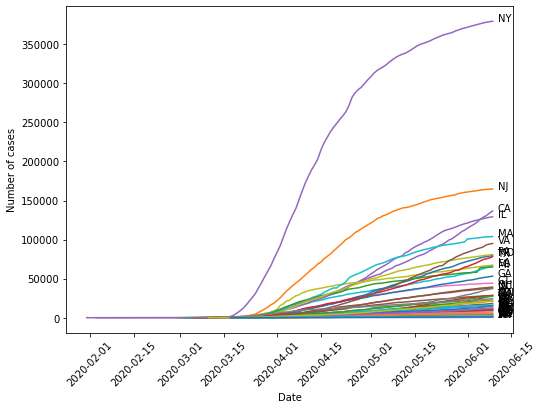

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

df_tmp = df_all_data.groupby(['Date', 'state'])[['Confirmed', 'Deaths']].sum()
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.sort_values(['state', 'Date'])
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])

# Get state names and iterate 
states = df_tmp['state'].unique()
for state in states:
    ax.plot(df_tmp[df_tmp['state']==state]['Date'], df_tmp[df_tmp['state']==state]['Confirmed'], label='Confirmed')
    
    # Get dates
    dates = df_tmp.loc[df_tmp['state'] == state, 'Date'].unique()
    
    # Annotate last date of state 
    plt.annotate(state, (dates[-1], df_tmp.loc[(df_tmp['Date'] == dates[-1]) & 
                                         (df_tmp['state'] == state), 
                                         'Confirmed'].values[0]), xytext=(5, 0), textcoords='offset points') 
plt.xlabel('Date')
plt.ylabel('Number of cases')
# Rotate the x-axis labels by 45 degrees
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', rotation=45)
plt.show()

We can see that New York is way out ahead in terms of Covid cases, second being New Jersey, which makes sense from a geographic / commuting sense.

Then California looks to be taking a swift upturn, and certainly needs to be kept an eye on.

### Then let's look at some of the conditions for infected people

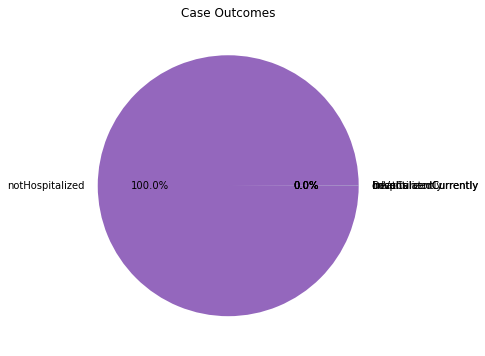

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

outcome_cols = ['notHospitalized', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'Deaths']

# First get the latest totals per state for all except 'Confirmed'
df_outcomes = df_all_data.groupby(['state'])[outcome_cols[1:]].last()
df_outcomes = df_outcomes.reset_index()

# Confirmed is a daily count so to compare apples and apples we need to make a cumulative count column
df_tmp = df_all_data.groupby(['state'])['Confirmed'].sum().reset_index()

df_outcomes = df_outcomes.merge(df_tmp, on="state")
df_outcomes.drop("state", axis=1, inplace=True)

df_outcomes['notHospitalized'] = df_outcomes['Confirmed'] - (df_outcomes['hospitalizedCurrently'] + df_outcomes['Deaths'])
df_outcomes.drop("Confirmed", axis=1, inplace=True)

plt.pie(df_outcomes.sum(), labels=df_outcomes.sum().index, autopct='%1.1f%%')
plt.title('Case Outcomes')
plt.show()

### We can see the Not Hospitalized counts are dwarfing the rest, so let's excude those

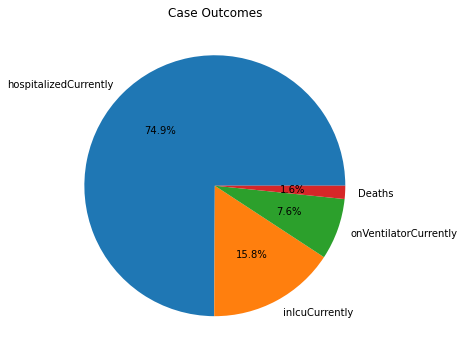

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.pie(df_outcomes[outcome_cols[1:]].sum(), labels=df_outcomes[outcome_cols[1:]].sum().index, autopct='%1.1f%%')
plt.title('Case Outcomes')
plt.show()

We can see from these two charts that the number of infected people who are hospitalised is <1%, and the resultant deaths are <1% of those - still way too many :-(

### Let's take a look at df_state_data

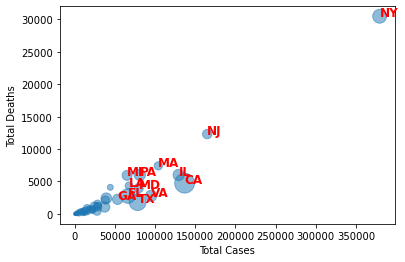

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(df_state_data['Confirmed'], df_state_data['Deaths'], 
            s=df_state_data['Population']/100000, alpha=0.5)

df_tmp = df_state_data.query('Confirmed > 50000 | Deaths > 4500')

for x, y, z in zip(df_tmp['Confirmed'], df_tmp['Deaths'], df_tmp['state']):
    ax.annotate(z, (x, y), fontsize=12, color='red', weight='bold')
    
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.show()

We can see the same picture with regards to those states heavily effected. The size of the bubble corelates to the population, so we can see with the size of California coupled with visable increase seen in the last graph again means this is something to keep a close eye on.

## OK let's go on to collate the forecast data, and see if we can forecast the next 10 days

In [11]:
if regenerate_forecast_data or get_fresh_data:
    df_all_states, df_all_states_TS = get_forecast_data(path, day0_feature, day0_minimum, checkpoint_interval)
else:
    df_all_states = pd.read_csv(path+'Data/df_all_states.csv')
    df_all_states_TS = pd.read_csv(path+'Data/df_all_states_TS.csv')

### Firstly the number of positive cases

In [12]:
def show_forecast(state):
    fig, ax = plt.subplots(figsize=(12, 6))

    df_tmp = df_forecast_data[df_forecast_data["state"]==state]

    ax.plot(df_tmp["Date"], df_tmp[day0_feature])
    ax.plot(df_tmp["Date"], df_tmp["forecast"])
    # ax.set_xticks(ax.get_xticks())
    # ax.tick_params(axis='x', rotation=90)

    # set the number of tick labels on the x-axis
    num_ticks = 7
    xtick_locs = ax.get_xticks()
    xtick_labels = [loc for loc in xtick_locs[::int(len(xtick_locs)/num_ticks)]]
    xtick_labels = [df_tmp.iloc[loc]['Date'] for loc in xtick_locs[::int(len(xtick_locs)/num_ticks)]]
    ax.set_xticks(xtick_locs[::int(len(xtick_locs)/num_ticks)])
    ax.set_xticklabels(xtick_labels)

    plt.show()

In [13]:
day0_minimum = 10
forecast_days = 10

day0_feature = 'positive'
df_forecast_data = get_forecast(path, day0_feature, forecast_days)
# df_forecast_data

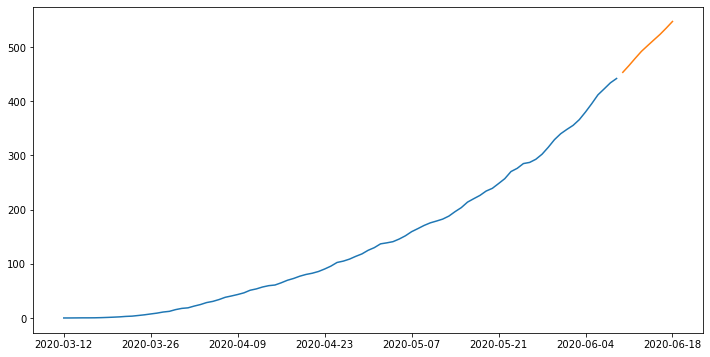

In [14]:
# Let's look at the forecast for North Carolina
show_forecast("NC")

### And what about forecasting the increase rate

In [15]:
day0_feature = 'positiveIncrease'
df_forecast_data = get_forecast(path, day0_feature, forecast_days)
# df_forecast_data

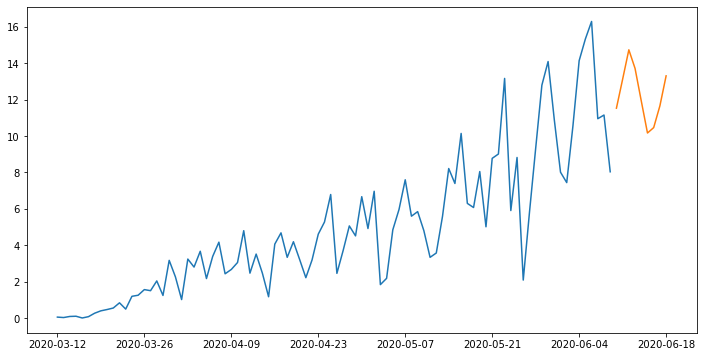

In [16]:
# Let's look at the forecast for North Carolina
show_forecast("NC")

Unsuprisingly, the forecast of both values shows an upwards trend at the time of generation :-(

## And finally, can we cluster the states into similarity in terms of it's Covid characteristics etc

First a helper function to allow us to pull out the fields pertinent to the clustering.

In [17]:
def cluster_columns_only(path, checkpoint_interval):
    """return just the fields we are going to use for K-Means clustering.

    Inputs:
    path                - File path
    checkpoint_interval - Interval between checkpoints

    Outputs:
    df_all_states       - State-level summaries with cluster assignments
    X                   - Data of just the relevant columns
    """

    df_all_states = pd.read_csv(path+'Data/df_all_states.csv')
    try:
        df_all_states.drop('Cluster', axis=1, inplace=True)
    except:
        pass

    toExclude = ['Province_State', 'state', 'MaxDays', 'Population', 'Confirmed', 'Deaths']

    X = df_all_states.copy()
    X.drop(list(toExclude), axis=1, inplace=True)

    toExclude = []
    for chk in range(1,10):
        for col in X.columns:
            if col.split('_')[0] == 'Day'+str(chk*checkpointInterval):
                toExclude.append(col)
    X.drop(toExclude, axis=1, inplace=True)
    X = X.astype(str).replace(',','', regex=True)
    X = X.astype(float)
    
    return df_all_states, X

And it's appropriate pipeline for the preprocessing.
- Scaling is important for K-Means because K-Means is a distance-based algorithm that clusters data points based on their Euclidean distance from a centroid. If the features in the dataset are not scaled, some of them may be given higher weights than others, which can result in clustering biases towards features with larger magnitudes. This can lead to poor cluster assignments and reduced accuracy
- Principal Component Analysis (PCA) is a dimensionality reduction technique that is used to reduce the number of features in a dataset, while retaining as much of the original variance and information in the dataset as possible. Therefore PCA can be useful for preprocessing data before clustering

In [18]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

Then get the training data columns, and pre-process them.

In [19]:
checkpointInterval = 7

df_all_states, X = cluster_columns_only(path, checkpointInterval)

In [20]:
preprocessed_X = preprocessor.fit_transform(X)
# preprocessed_X

## But how can we determine the right number of clusters?

There are two good methods we can use to try and determine the appropriate value for k. The elbow method and silhouette method.
- The elbow method involves plotting the relationship between the number of clusters (k) and the sum of squared distances between data points and their assigned cluster center. The ideal k value is the point where the decrease in sum of squared distances starts to level off (i.e., the elbow point)
- The silhouette method involves calculating the average silhouette score for each number of clusters k. The silhouette score measures how similar a data point is to its assigned cluster compared to other clusters. It ranges from -1 to 1, where values closer to 1 indicate that a data point is well matched to its cluster

### Elbow method to select k

In [21]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1972,
}

# A list holds the sum of squared errors (SSE) values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_X)
    sse.append(kmeans.inertia_)

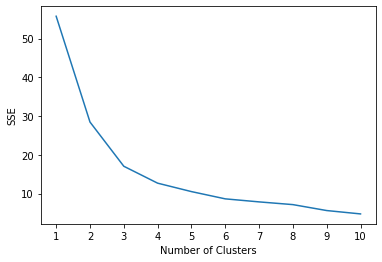

In [22]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhouette method to select k

In [23]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_X)
    score = silhouette_score(preprocessed_X, kmeans.labels_)
    silhouette_coefficients.append(score)

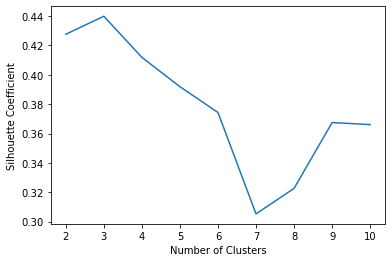

In [24]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Both methods indicate 3 is a good cluster size, so let's build it with that.

In [25]:
n_clusters = 3

In [26]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [27]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [28]:
pipe.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

Get the predicted labels, and the associated silhoutte score.

In [29]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_
predicted_labels

array([1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0,
       2, 1, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1, 2,
       2, 0, 2, 1, 2, 2])

In [30]:
silhouette_score(preprocessed_X, predicted_labels)

0.4398675185111555

So silhouette ranges from -1 to 1, so this is not bad - pretty confident :-)

### Finally let's look at these as clusters

In [31]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(X),
    columns=["component_1", "component_2"],
)

# Add in the cluster
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

# Add in the State code
pcadf['state'] = df_all_states['state'].to_list()
pcadf.head()

,component_1,component_2,predicted_cluster,state
0,-1.024133,-0.931543,1,AL
1,1.739032,0.159084,2,AK
2,0.359207,0.314087,2,AZ
3,-0.141761,-1.083564,1,AR
4,-0.429788,0.874748,0,CA


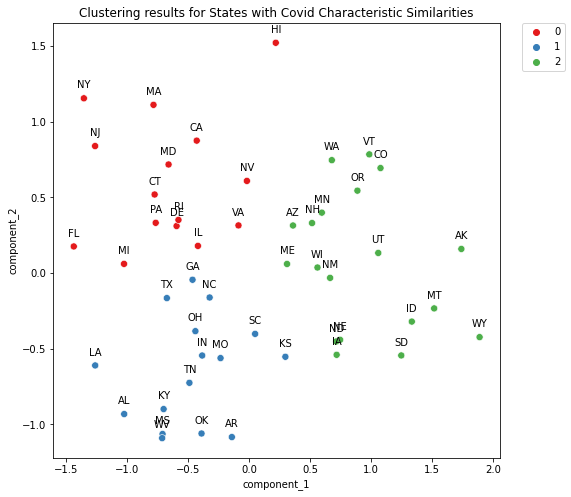

In [32]:
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set1",
)

# loop through the data and add annotations for each point
for i in range(len(pcadf)):
    label = pcadf.iloc[i]['state']  # get the label from the 'state' column in the data
    x = pcadf.iloc[i]['component_1']  # get the x-coordinate
    y = pcadf.iloc[i]['component_2']  # get the y-coordinate
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')


scat.set_title("Clustering results for States with Covid Characteristic Similarities")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

This looks pretty good to me. Cluster 0 has NY, NJ, CA etc, which makes sense, and I think there are some good insights here as to how things could progress.